## Imports

In [1]:
import duckdb
import networkx as nx
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import igraph as ig
import leidenalg

from collections import defaultdict
from datetime import datetime
from geopy.distance import great_circle
from pyvis.network import Network
from shapely import wkt
import shapely.geometry

import geopandas as gpd
import matplotlib.colors as mcolors

from networkx.algorithms.community import quality
import pickle


## Constants

In [2]:
X_SHOP_PHYSICAL_BRANDS_PCT = 'RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT'
X_SHOP_DIMENSIONS = ['physical']
X_SHOP_DIMENSIONS_ALL = ['physical']
LOCATION_NAME = 'LOCATION_NAME'
TOP_CATEGORY = 'TOP_CATEGORY'
RAW_NUM_CUSTOMERS = 'RAW_NUM_CUSTOMERS'
RAW_NUM_TRANSACTIONS = 'RAW_NUM_TRANSACTIONS'
RAW_TOTAL_SPEND = 'RAW_TOTAL_SPEND'
POLYGON = 'POLYGON_WKT'

SPEND_PLACES_PATH = 'data/san-diego-county-places-spend.parquet' # added based on joined output

## Load Data

In [3]:
r1 = duckdb.read_parquet(SPEND_PLACES_PATH)
df = r1.to_df()
df.head()

,CITY,LATITUDE,LONGITUDE,PARENT_PLACEKEY,PLACEKEY,POLYGON_WKT,POSTAL_CODE,REGION,SAFEGRAPH_BRAND_IDS,STREET_ADDRESS,...,SPEND_BY_TRANSACTION_INTERMEDIARY,SPEND_DATE_RANGE_END,SPEND_DATE_RANGE_START,SPEND_PCT_CHANGE_VS_PREV_MONTH,SPEND_PCT_CHANGE_VS_PREV_YEAR,SPEND_PER_TRANSACTION_BY_DAY,SPEND_PER_TRANSACTION_PERCENTILES,SUB_CATEGORY,TOP_CATEGORY,TRANSACTION_INTERMEDIARY
0,San Diego,32.755488,-117.107622,None,22j-222@5z5-qdx-6zf,POLYGON ((-117.10754558444023 32.7555074919251...,92105.0,CA,SG_BRAND_1f2a4b730dc533366115ba7f5168b074,4090 El Cajon Blvd Ste C,...,"{""key_value"":[{""key"":""No intermediary"",""value""...",2025-08-01,2025-07-01,-45.0,NaN,"[null,null,null,null,null,null,34.77,null,null...","{""25"":16.91,""75"":47.13}",Limited-Service Restaurants,Restaurants and Other Eating Places,"{""key_value"":[{""key"":""No intermediary"",""value""..."
1,San Diego,32.762727,-117.131964,None,22m-222@5z5-qdy-d9z,POLYGON ((-117.13201920422857 32.7627738709169...,92116.0,CA,None,2873 Adams Ave,...,"{""key_value"":[{""key"":""Square"",""value"":203.92}]}",2025-08-01,2025-07-01,9.0,318.0,"[null,11.5,null,15.24,null,null,27.6,null,null...","{""25"":10.49,""75"":40.66}",Snack and Nonalcoholic Beverage Bars,Restaurants and Other Eating Places,"{""key_value"":[{""key"":""Square"",""value"":10}]}"
2,San Diego,32.889963,-117.179930,None,22r-222@5z5-px8-v75,POLYGON ((-117.18009507918524 32.8901942559195...,92121.0,CA,None,6364 Ferris Sq,...,"{""key_value"":[{""key"":""No intermediary"",""value""...",2025-08-01,2025-07-01,-55.0,-19.0,"[null,null,null,26.38,null,5,null,null,null,24...","{""25"":13.61,""75"":47.7}",None,"Advertising, Public Relations, and Related Ser...","{""key_value"":[{""key"":""No intermediary"",""value""..."
3,La Jolla,32.853546,-117.254233,zzy-222@5z5-pmy-r49,22t-222@5z5-pmy-mzf,POLYGON ((-117.25400457128175 32.8536535551412...,92037.0,CA,None,2261 Avenida de la Playa,...,"{""key_value"":[{""key"":""Shopify"",""value"":421.4}]}",2025-08-01,2025-07-01,235.0,30.0,"[null,null,31.25,null,null,null,53.88,null,53....","{""25"":35.53,""75"":70.99}",Sporting Goods Stores,"Sporting Goods, Hobby, and Musical Instrument ...","{""key_value"":[{""key"":""Shopify"",""value"":7}]}"
4,San Ysidro,32.545093,-117.038717,None,234-222@5z5-wp2-26k,POLYGON ((-117.0387910794577 32.54518979730449...,92173.0,CA,SG_BRAND_5179b21fc1d50950b99b4eecaa48c614,4449 Camino de la Plz,...,"{""key_value"":[{""key"":""No intermediary"",""value""...",2025-08-01,2025-07-01,23.0,0.0,"[9.04,3.88,9.21,12.28,19.16,21.02,11.08,28.73,...","{""25"":5.39,""75"":18.11}",Limited-Service Restaurants,Restaurants and Other Eating Places,"{""key_value"":[{""key"":""No intermediary"",""value""..."


In [4]:
df.columns

Index(['CITY', 'LATITUDE', 'LONGITUDE', 'PARENT_PLACEKEY', 'PLACEKEY',
       'POLYGON_WKT', 'POSTAL_CODE', 'REGION', 'SAFEGRAPH_BRAND_IDS',
       'STREET_ADDRESS', 'BRANDS', 'BUCKETED_CUSTOMER_FREQUENCY',
       'BUCKETED_CUSTOMER_INCOMES', 'CUSTOMER_HOME_CITY', 'DAY_COUNTS',
       'LOCATION_NAME', 'MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY',
       'MEAN_SPEND_PER_CUSTOMER_BY_INCOME', 'MEDIAN_SPEND_PER_CUSTOMER',
       'MEDIAN_SPEND_PER_TRANSACTION', 'NAICS_CODE', 'ONLINE_SPEND',
       'ONLINE_TRANSACTIONS', 'RAW_NUM_CUSTOMERS', 'RAW_NUM_TRANSACTIONS',
       'RAW_TOTAL_SPEND', 'RELATED_BUYNOWPAYLATER_SERVICE_PCT',
       'RELATED_CROSS_SHOPPING_LOCAL_BRANDS_PCT',
       'RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT',
       'RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT',
       'RELATED_CROSS_SHOPPING_SAME_CATEGORY_BRANDS_PCT',
       'RELATED_DELIVERY_SERVICE_PCT', 'RELATED_PAYMENT_PLATFORM_PCT',
       'RELATED_RIDESHARE_SERVICE_PCT', 'RELATED_STREAMING_CABLE_PCT',
       'RELATED_WIR

In [5]:
def parse_json_to_tuple(json_str: str) -> list[tuple[str, int]]:
    if not json_str:
        return None
    try:
        data_dict = json.loads(json_str)

        # Handle the nested structure
        if isinstance(data_dict, dict) and "key_value" in data_dict:
            return [(item["key"], item["value"]) for item in data_dict["key_value"]]

        # If it's already a flat dict
        elif isinstance(data_dict, dict):
            return [(k, v) for k, v in data_dict.items()]

        # If it's a list of dicts already
        elif isinstance(data_dict, list):
            return [(item["key"], item["value"]) for item in data_dict]

        return None
    except (ValueError, SyntaxError, KeyError, TypeError):
        return None

## Parse Related Cross Shopping Column

In [6]:
df['parsed_physical_brands'] = df[X_SHOP_PHYSICAL_BRANDS_PCT].apply(parse_json_to_tuple)

## Set Polygon Column for Maps

In [7]:
df["GEOMETRY"] = df['POLYGON_WKT'].apply(lambda x: wkt.loads(x) if pd.notna(x) else None)

## Construct the graph

### Cross shopping implementation

This implementation accounts for location as nodes and uses cross shopping brands as edges.

Notes:
-  First builds brand index for effeciency, such that every location_node has an associated brand. We use location name as the brand, as not all locations have associated brands from SafeGraph but attributed brand names equal to brand_name. Structure in comments. 
- 

In [8]:
# intialize graphs
graphs = {
    "physical": nx.DiGraph()
}

df["brand_sets"] = df.apply(lambda row: {
    "physical":     row["parsed_physical_brands"]
}, axis=1)

In [9]:
# build brand-to-locations index for faster lookup
# builds an index like:
# {
#     "physical": {
#         "Target": [
#             "Target (33.123, -117.456)",
#             "Target (34.789, -118.123)"
#         ],
#         "Walmart": [
#             "Walmart (33.456, -117.789)"...


def build_brand_index(graphs_dict):
    """Build index: brand -> list of node_ids with that brand"""
    brand_index = {}
    for graph_name, G in graphs_dict.items():
        brand_index[graph_name] = defaultdict(list)
        for node_id in G.nodes():
            brand = G.nodes[node_id].get('brand')
            if brand:
                brand_index[graph_name][brand].append(node_id)
    return brand_index

# add all nodes with location name as brand
def add_nodes(row):
    location = row[LOCATION_NAME]
    latitude = row["LATITUDE"]
    longitude = row["LONGITUDE"]
    node_id = f"{location} ({latitude:.6f}, {longitude:.6f})"
    
    for g in graphs.values():
        g.add_node(
            node_id,
            name=location,
            brand=location,
            label=location,
            category=row[TOP_CATEGORY],
            num_customers=row[RAW_NUM_CUSTOMERS],
            num_transactions=row[RAW_NUM_TRANSACTIONS],
            total_spend=row[RAW_TOTAL_SPEND],
            latitude=latitude,
            longitude=longitude,
            geometry_wkt=row["POLYGON_WKT"],
        )

df.apply(add_nodes, axis=1)

# with our graphs and nodes built, we can use the function above to build the brand index
brand_index = build_brand_index(graphs)

# now we can add edges using the brand index
def add_cross_shopping_edges(row):
    location_or_brand = row[LOCATION_NAME]
    latitude = row["LATITUDE"]
    longitude = row["LONGITUDE"]
    source_node_id = f"{location_or_brand} ({latitude:.6f}, {longitude:.6f})"
    
    for graph_name, brand_list in row["brand_sets"].items(): # this gets our cross shopping dimension brands
        if not brand_list:
            continue
        
        G = graphs[graph_name]
        
        for brand, pct in brand_list: # brand list is a list of tuples with brand name and percentage
            weight = pct / 100
            if weight > 0.25: # bumping this up to 25% to reduce noise
                # we use index to find target nodes quickly, reference structure above for clarification
                # this is a similar implementation to the original implementation we are just now 
                # mapping brand to location nodes

                # this retrieves the list of location nodes that have the brand (location name eg Walmart, Starbucks)
                # and returns a list of node ids which includes the location name and coordinates
                target_nodes = brand_index[graph_name].get(brand, [])
                
                # now we iterate through the target nodes and add edges
                for target_node_id in target_nodes:
                    # we don't want to add an edge to itself
                    if target_node_id != source_node_id:
                        # if the brand already exists, we aggregate the weight
                        # this occurs because we may have multiple location nodes for the same brand
                        # so we take the max of the weights
                        # conversly, we don't know the exact location of the brand, so we use the max

                        # practically - this checks if "Walmart" is already in the graph (remember this is now our source node)
                        # and if so, it aggregates the weight of the edge
                        if G.has_edge(source_node_id, target_node_id):
                            G[source_node_id][target_node_id]['weight'] = max(
                                G[source_node_id][target_node_id].get('weight', 0), 
                                weight
                            )
                        else:
                            G.add_edge(source_node_id, target_node_id, weight=weight)

df.apply(add_cross_shopping_edges, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
8532    None
8533    None
8534    None
8535    None
8536    None
Length: 8537, dtype: object

### Continue brand implementation

In [10]:
# check graph nodes and edge counts
print('Physical: ', graphs['physical'].number_of_nodes(), graphs['physical'].number_of_edges())

Physical:  8536 6092856


In [11]:
# filter out isolated nodes
for name, G in graphs.items():
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
    print(f"{name} graph after removing isolates: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

physical graph after removing isolates: 8523 nodes, 6092856 edges


## Export Graph to GEXF

In [12]:
# export the graph to a GEXF file for visualization in Gephi
def export_graph(G: nx.DiGraph, name: str):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"graphs/{name}_graph_{timestamp}.gexf"
    nx.write_gexf(G, output_file)

for name, G in graphs.items():
    export_graph(G, name)

KeyboardInterrupt: 

## Notes
Overview
- physical graph, will use this for all downstream (provide full end point to businesses)
- louvain is baseline, laiden is primary model
- Goal/Eval: Top N locations to provide to business / community detection

## Clustering

### Global Clustering Coefficient

 >The global clustering coefficient (aka "transitivity") is based on triplets of nodes. A triplet consists of three connected nodes. A triangle therefore includes three closed triplets, one centered on each of the nodes (n.b. this means the three triplets in a triangle come from overlapping selections of nodes). The global clustering coefficient is the number of closed triplets (or 3 x triangles) over the total number of triplets (both open and closed). The first attempt to measure it was made by Luce and Perry (1949). This measure gives an indication of the clustering in the whole network (global), and can be applied to both undirected and directed networks.

tldr: transitivity ranges from 0 to 1 and can be interpreted as: the probability that two nodes that share a neighbor are themselves connected.

 GeeksforGeeks. (2022, October 31). Clustering coefficient in graph Theory. GeeksforGeeks. https://www.geeksforgeeks.org/dsa/clustering-coefficient-graph-theory/

#### NOTE:
Adjusted this slightly. Now utilizes an appoximate method (often yields similar results) using with node and edge increase with location based method. We will also save output to pickle/dataframe

In [13]:
def compute_global_clustering_coeff(G: nx.DiGraph):
    """Compute global clustering with optimization for large graphs."""
    UG = G.to_undirected()
    
    # for the physical graph, we use the approximation method, too large to compute exactly
    if G.number_of_edges() > 500000:
        print(f"  Graph has {G.number_of_edges()} edges - using approximation...")
        # sample nodes for faster computation
        nodes = list(UG.nodes())
        if len(nodes) > 5000:
            import random
            sample_nodes = random.sample(nodes, 5000)
            local_clust = nx.clustering(UG, nodes=sample_nodes)
        else:
            local_clust = nx.clustering(UG)
        return np.mean(list(local_clust.values()))
    else:
        # we will exact computation for smaller graphs if relevant later
        return nx.transitivity(UG)

for name, G in graphs.items():
    print(f"Computing clustering for {name} graph ({G.number_of_edges()} edges)...")
    gcc = compute_global_clustering_coeff(G)
    print(f"Global Clustering Coefficient for {name} graph: {gcc}")

Computing clustering for physical graph (6092856 edges)...
  Graph has 6092856 edges - using approximation...
Global Clustering Coefficient for physical graph: 0.593071963711977


In [14]:
# Collect results in a list
results = []

for name, G in graphs.items():
    print(f"Computing clustering for {name} graph ({G.number_of_edges()} edges)...")
    gcc = compute_global_clustering_coeff(G)
    print(f"Global Clustering Coefficient for {name} graph: {gcc}")
    
    results.append({
        'graph_name': name,
        'clustering_coefficient': gcc,
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'method': 'approximation' if G.number_of_edges() > 500000 else 'exact'
    })

# Create DataFrame and save
clustering_df = pd.DataFrame(results)
clustering_df.to_csv('clustering_results.csv', index=False)
clustering_df.to_parquet('clustering_results.parquet', index=False)  # More efficient

print(f"\nResults saved:")
print(clustering_df)

Computing clustering for physical graph (6092856 edges)...
  Graph has 6092856 edges - using approximation...
Global Clustering Coefficient for physical graph: 0.5924510344513434

Results saved:
  graph_name  clustering_coefficient  num_nodes  num_edges         method
0   physical                0.592451       8523    6092856  approximation


In [15]:
# def compute_global_clustering_coeff(G: nx.DiGraph):
#     # convert digraph to undirected graph
#     UG = G.to_undirected()
#     return nx.transitivity(UG)

# for name, G in graphs.items():
#     gcc = compute_global_clustering_coeff(G)
#     print(f"Global Clustering Coefficient for {name} graph: {gcc}")

### PageRank

We utilize PageRank to identify the top 10 most influential "hubs" in the ecosystem

In [102]:
def compute_pagerank(G: nx.DiGraph):
    """Compute PageRank with optimization for large graphs."""
    if G.number_of_edges() > 500000:
        print(f"  Large graph: {G.number_of_edges()} edges - using optimized settings...")
        pagerank = nx.pagerank(G, alpha=0.85, weight='weight', 
                              max_iter=50, tol=1e-5)
    else:
        pagerank = nx.pagerank(G, alpha=0.85, weight='weight')
    return sorted(pagerank.items(), key=lambda item: item[1], reverse=True)

# Use optimized versions
print("Computing PageRank for physical graph...")
pagerank = compute_pagerank(graphs['physical'])
print(f"✓ PageRank complete: {len(pagerank)} nodes")

Computing PageRank for physical graph...
  Large graph: 6092856 edges - using optimized settings...
✓ PageRank complete: 8523 nodes


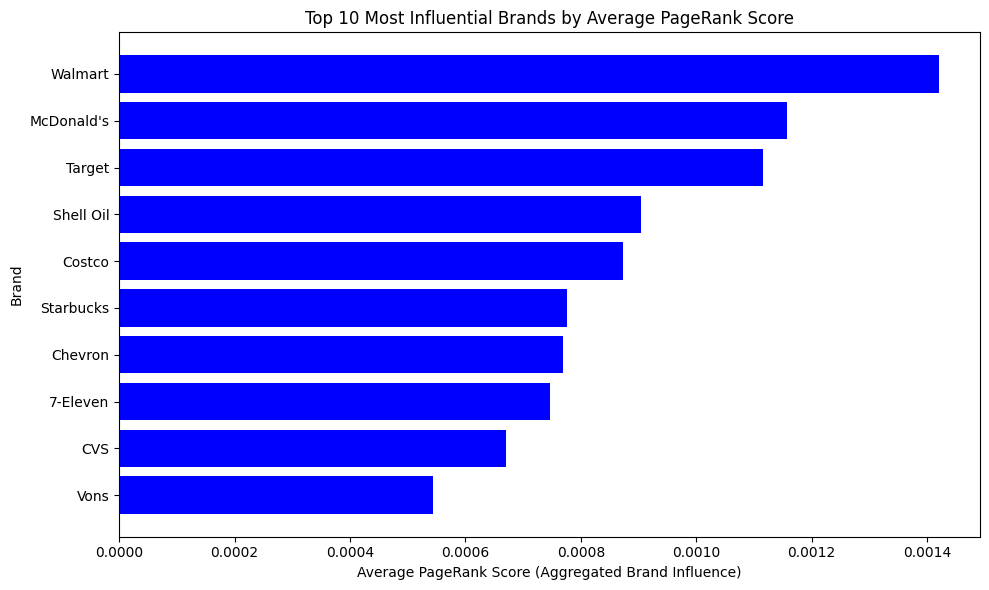

Top 10 Most Influential Brands by Average PageRank Score (Aggregated):

  location_name  avg_brand_pagerank
0       Walmart            0.001421
1    McDonald's            0.001157
2        Target            0.001117
3     Shell Oil            0.000904
4        Costco            0.000873
5     Starbucks            0.000776
6       Chevron            0.000769
7      7-Eleven            0.000747
8           CVS            0.000671
9          Vons            0.000544


In [115]:
# Convert the list of tuples from pagerank to a DataFrame
pagerank_df = pd.DataFrame(
    pagerank,
    columns=['node_id', 'pagerank_score']
)

# Extract the location name (brand name)
def extract_location_name(node_id):
    """Extracts the location name from the node_id string."""
    return node_id.split(' (')[0]

pagerank_df['location_name'] = pagerank_df['node_id'].apply(extract_location_name)

# Group by location name and average the PageRank scores to calculate the approx. market influence for each brand.
brand_influence_df = pagerank_df.groupby('location_name')['pagerank_score'].mean().reset_index()
brand_influence_df.rename(columns={'pagerank_score': 'avg_brand_pagerank'}, inplace=True)

# Find the top 10 most influential brands
top_n = 10
top_10_brands = brand_influence_df.sort_values(
    'avg_brand_pagerank',
    ascending=False
).head(top_n).reset_index(drop=True)

# Visualization Top 10 Brands as Barchart 
display_names = top_10_brands['location_name'].tolist()
scores = top_10_brands['avg_brand_pagerank'].tolist()

plt.figure(figsize=(10, 6))
plt.barh(display_names, scores, color='blue')  # Use the brand names for the y-axis
plt.xlabel("Average PageRank Score (Aggregated Brand Influence)")
plt.ylabel("Brand")
plt.title(f"Top {top_n} Most Influential Brands by Average PageRank Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"Top {top_n} Most Influential Brands by Average PageRank Score (Aggregated):\n")
print(top_10_brands)

## Degree Analysis

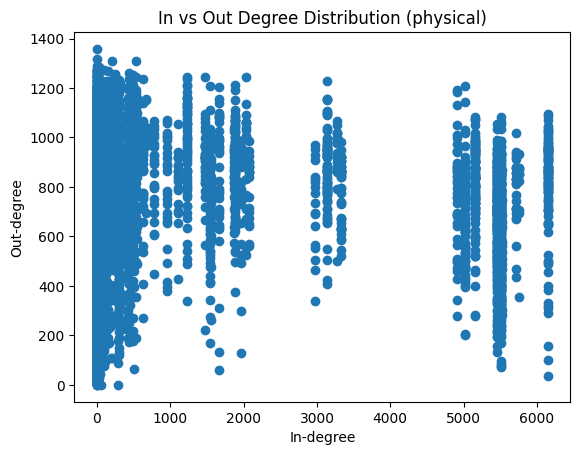

In [19]:
# find most influential nodes using out_degree 
def plot_in_out_degree(G: nx.DiGraph, related_x_shop_type: str):
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    plt.scatter(in_degrees.values(), out_degrees.values())
    plt.xlabel("In-degree")
    plt.ylabel("Out-degree")
    plt.title("In vs Out Degree Distribution ({})".format(related_x_shop_type))
    plt.show()

plot_in_out_degree(graphs['physical'], 'physical')

In [20]:
# find the top n nodes with the highest out_degree
def top_out_degree_nodes(num_nodes: int, G: nx.DiGraph) -> list[tuple[str, int]]:
    out_degrees = dict(G.out_degree())
    return sorted(out_degrees.items(), key=lambda item: item[1], reverse=True)[:num_nodes]

top10_out_physical = top_out_degree_nodes(10, graphs['physical'])

for dimension in X_SHOP_DIMENSIONS:
    print(f"Top 10 out-degree nodes for {dimension} graph:")
    top10_out = top_out_degree_nodes(10, graphs[dimension])
    for node, degree in top10_out:
        print(f"{node}: {degree}")

Top 10 out-degree nodes for physical graph:
Best Bev (32.640567, -117.095608): 1358
Lucky Chinese Food (32.839723, -116.985286): 1319
Burger King (32.805863, -116.971452): 1311
Denny's (33.183544, -117.328322): 1309
Cali Baguette Express (32.756885, -117.083872): 1287
Pizza Hut (32.711447, -117.130919): 1286
dd's DISCOUNTS (32.697046, -117.118591): 1282
Fruity Loco (32.707554, -116.994860): 1276
China Fun (33.021375, -117.073442): 1274
Applebee's (33.110036, -117.098341): 1271


In [21]:
# find the top n nodes with the highest in_degree
def top_in_degree_nodes(num_nodes: int, G: nx.DiGraph) -> list[tuple[str, int]]:
    in_degrees = dict(G.in_degree())
    return sorted(in_degrees.items(), key=lambda item: item[1], reverse=True)[:num_nodes]

for dimension in X_SHOP_DIMENSIONS:
    print(f"Top 10 in-degree nodes for {dimension} graph:")
    top10_in = top_in_degree_nodes(10, graphs[dimension])
    for node, degree in top10_in:
        print(f"{node}: {degree}")

Top 10 in-degree nodes for physical graph:
McDonald's (32.545093, -117.038717): 6149
McDonald's (32.915440, -117.130283): 6149
McDonald's (32.652712, -117.089166): 6149
McDonald's (32.980302, -117.249532): 6149
McDonald's (33.371486, -117.252110): 6149
McDonald's (33.128987, -117.090946): 6149
McDonald's (33.203581, -117.364005): 6149
McDonald's (32.748843, -117.150728): 6149
McDonald's (33.045626, -117.261495): 6149
McDonald's (33.133586, -117.121136): 6149


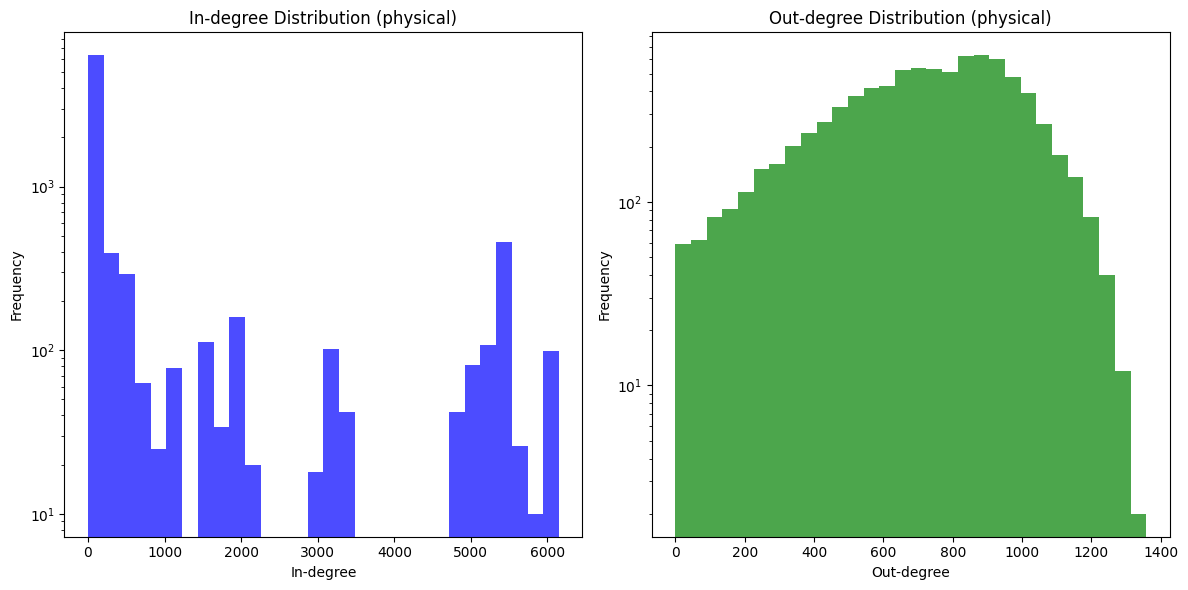

In [22]:
# plot distribution of in-degrees and out-degrees
def plot_degree_distribution(G: nx.DiGraph, related_x_shop_type: str):
    in_degrees = [d for n, d in G.in_degree()]
    out_degrees = [d for n, d in G.out_degree()]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(in_degrees, bins=30, color='blue', alpha=0.7, log=True)
    plt.xlabel("In-degree")
    plt.ylabel("Frequency")
    plt.title("In-degree Distribution ({})".format(related_x_shop_type))

    plt.subplot(1, 2, 2)
    plt.hist(out_degrees, bins=30, color='green', alpha=0.7, log=True)
    plt.xlabel("Out-degree")
    plt.ylabel("Frequency")
    plt.title("Out-degree Distribution ({})".format(related_x_shop_type))

    plt.tight_layout()
    plt.show()

plot_degree_distribution(graphs['physical'], 'physical')

### Degree Neighbors

In [23]:
# find all nodes that have an incoming edge into a specific node
def first_degree_in_neighbors(node: str, G: nx.DiGraph) -> set[str]:
    """
    Return all 1st-degree neighbors that have an incoming edge into `node`.
    """
    if node not in G:
        return set()
    return set(G.predecessors(node))

def first_degree_out_neighbors(node: str, G: nx.DiGraph) -> set[str]:
    """
    Return the 1st-degree neighbors that have an outgoing edge from `node`.
    """
    if node not in G:
        return set()
    return set(G.successors(node))

def second_degree_in_neighbors(node: str, G: nx.DiGraph) -> set[str]:
    """
    Return the 2nd-degree neighbors that have an incoming edge into `node`.
    Excludes the node itself and direct 1st-degree neighbors.
    """
    if node not in G:
        return set()
    first = set(G.successors(node))
    second = set()
    for n in first:
        second.update(G.successors(n))
    second -= first
    second.discard(node)
    return second

In [24]:
first_degree_in_neighbors("Tilly's (32.768785, -117.147968)", graphs['physical'])

{'Al Qosh Gift Shop (32.790019, -117.100103)',
 'Beach Terrace (33.159253, -117.354371)',
 'Casablanca Lounge (32.714122, -117.160448)',
 'Chevron (32.669162, -117.113042)',
 'Cycle Gear (32.596226, -117.075582)',
 "Dunkin' (33.297275, -117.349694)",
 "Harry's Taco Club (32.798625, -117.252445)",
 'High Tech Auto (33.145598, -117.198436)',
 'Old World Meat Company (33.138985, -117.047794)',
 'Pho Hung Cali (32.611362, -117.082148)',
 'Sephora (32.624252, -116.966474)',
 'The UPS Store (32.791281, -117.080615)',
 'Windsor (32.655176, -117.065938)',
 'Zoo Brew (32.735958, -117.151021)'}

## Geo-Filters 

We define a function that allows us to specify a radius prior to community detection. We aim to evaluate various cross-shopping communities with a geographic filter (radius in miles). This uses the intial graph created and provides a subgraph based on this determination. We can use either a center location for broader analyis, or a specific location in our dataset.

First, we define a helper function to filer the nodes based on the set radius in miles. Then, we define a function that utlizes the subgraph method from NetworkX to filter based on these filtered nodes. We also use this opportunity to return only connected brands as a parameter to further filter the graph.

In [25]:
# helper function to get nodes within a radius
def get_nodes_within_radius(G, center_node, radius_mi):
    """
    Get all nodes within a given radius (in km) of a center node.
    Uses geodesic distance for accuracy.
    """
    if center_node not in G:
        return []
    
    center_lat = G.nodes[center_node].get('latitude')
    center_lon = G.nodes[center_node].get('longitude')
    
    if center_lat is None or center_lon is None:
        print(f"Warning: {center_node} does not have latitude/longitude data")
        return []
    
    center_point = (center_lat, center_lon)
    nodes_within_radius = []
    
    for node in G.nodes():
        node_lat = G.nodes[node].get('latitude')
        node_lon = G.nodes[node].get('longitude')
        
        if node_lat is None or node_lon is None:
            continue
        
        node_point = (node_lat, node_lon)
        distance = great_circle(center_point, node_point).miles
        
        if distance <= radius_mi:
            nodes_within_radius.append(node)
    
    nodes_within_radius.sort(key=lambda x: x[1])
    return nodes_within_radius

In [26]:
def filter_graph_by_radius(G: nx.DiGraph, center_node: str, radius_mi: float, 
                           include_connected_brands: bool = True) -> nx.DiGraph:
    """
    Filter a graph to include only nodes within a specified radius of a center node.
    Optionally includes brand nodes connected to location nodes within the radius.
    
    Parameters:
    -----------
    G : NetworkX DiGraph
        The original graph
    center_node : str
        The center node (location) to filter around
    radius_mi : float
        Radius in miles
    include_connected_brands : bool, default=True
        If True, includes brand nodes connected to location nodes within radius.
        If False, only includes location nodes within radius.
    
    Returns:
    --------
    NetworkX DiGraph : Filtered subgraph containing only nodes within radius
    """
    if center_node not in G:
        print(f"Warning: {center_node} not found in graph")
        return nx.DiGraph()
    
    # Get location nodes within radius (nodes with lat/lon)
    location_nodes_within_radius = get_nodes_within_radius(G, center_node, radius_mi)
    
    if not location_nodes_within_radius:
        print(f"No nodes found within {radius_mi} miles of {center_node}")
        return nx.DiGraph()
    
    # Set of nodes to include in filtered graph
    nodes_to_include = set(location_nodes_within_radius)
    
    # Optionally include brand nodes connected to location nodes within radius
    if include_connected_brands:
        for location in location_nodes_within_radius:
            # Get all neighbors (brands) connected to this location
            neighbors = list(G.successors(location)) + list(G.predecessors(location))
            nodes_to_include.update(neighbors)
    
    # Create subgraph with only the selected nodes
    filtered_graph = G.subgraph(nodes_to_include).copy()
    
    print(f"Filtered graph: {filtered_graph.number_of_nodes()} nodes, "
          f"{filtered_graph.number_of_edges()} edges "
          f"(from {G.number_of_nodes()} nodes, {G.number_of_edges()} edges)")
    
    return filtered_graph

## Community Detection

### Louvain Communities

A Louvain community is a group of nodes in a network that are more densely connected to each other than to the rest of the network, identified by the Louvain algorithm through greedy modularity maximization. The algorithm iteratively moves nodes between communities to increase modularity and aggregates communities hierarchically until no further improvement is possible, producing a partition that reveals the network’s latent structure. In the context of a business cross-shopping network, Louvain communities correspond to groups of stores that share many customers relative to the broader network, highlighting patterns of customer behavior that may not align with obvious categories (Blondel et al., 2008).

Citation:
Blondel, V. D., Guillaume, J.-L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of Statistical Mechanics: Theory and Experiment, 2008(10), P10008. https://doi.org/10.1088/1742-5468/2008/10/P10008

In [27]:
def get_louvain_communities(G: nx.DiGraph, weight='weight', seed=47):
    """Detect communities in the graph using the Louvain method."""
    communities = nx.community.louvain_communities(G, weight=weight, seed=seed)

    return communities

In [28]:
# compute Louvain communities for each graph
louvain_communities_physical = get_louvain_communities(graphs['physical'])

# size of communities in each graph
print(len(louvain_communities_physical))

3


### Leiden Communities
Leiden communities are groups of nodes that are densely connected internally and sparsely connected externally, identified by the Leiden algorithm. The algorithm iteratively moves nodes between communities to maximize a quality function (e.g., modularity), refines communities to ensure internal connectivity, and aggregates communities hierarchically until no further improvement is possible. Compared to Louvain, Leiden produces more stable, internally connected, and interpretable communities, making it particularly useful for real-world networks such as cross-shopping networks where loosely connected nodes and disconnected subgroups are common (Traag et al., 2019).

Traag, V. A., Waltman, L., & van Eck, N. J. (2019). From Louvain to Leiden: guaranteeing well-connected communities. Scientific Reports, 9, 5233. https://arxiv.org/abs/1810.08473

In [29]:
def convert_to_igraph(G: nx.DiGraph) -> tuple[ig.Graph, list]:
    """
    Convert a NetworkX DiGraph to an iGraph Graph.
    Returns the graph and a list of node IDs in the same order as iGraph vertices.
    """
    ig_graph = ig.Graph.from_networkx(G)
    
    # Get the node ids in the same order as iGraph vertices preserves the node order
    nx_node_ids = list(G.nodes())
    
    return ig_graph, nx_node_ids

# Convert membership to list of sets
def leiden_to_sets(graph, partition, nx_node_ids):
    """
    Convert Leiden partition to list of sets of node IDs.
    
    Parameters:
    -----------
    graph : ig.Graph
        The iGraph graph
    partition : leidenalg.RBConfigurationVertexPartition
        The partition object
    nx_node_ids : list
        List of NetworkX node IDs in the same order as iGraph vertices
    """
    communities = defaultdict(set)
    
    # Map partition membership to NetworkX node IDs
    for i, cid in enumerate(partition.membership):
        node_id = nx_node_ids[i]  # Get the actual node_id from NetworkX
        communities[cid].add(node_id)
    
    return list(communities.values())


In [30]:
ig_physical, nx_nodes_physical = convert_to_igraph(graphs['physical'])

In [31]:
leiden_communities_physical = leidenalg.find_partition(graph=ig_physical,
                                                  partition_type=leidenalg.ModularityVertexPartition, 
                                                  weights='weight')


In [32]:
leiden_set_physical = leiden_to_sets(ig_physical, leiden_communities_physical, nx_nodes_physical)

### Evaluate Community Quality

In [33]:
def evaluate_community_quality(G: nx.DiGraph, communities: list[set[str]]):
    """Evaluate the quality of the detected communities using modularity."""
    Q = quality.modularity(G, communities)
    return Q

In [34]:
mod = evaluate_community_quality(graphs['physical'], louvain_communities_physical)

print("Evaluating Louvain Communities")
print(f"Modularity Scores (physical): {mod}")
print()
print("Evaluating Leiden Communities")
print(f"Modularity Scores (physical): {leiden_communities_physical.modularity}")

Evaluating Louvain Communities
Modularity Scores (physical): 0.13341867779125569

Evaluating Leiden Communities
Modularity Scores (physical): 0.09735949799963073


## Mapping

We define a mapping function `visualize_filtered_graph` to display nodes in the graph. This function returns a folium map object including:
- Lines drawn between node of interest and recommended partnerships 
- Pop ups to provide additional detail (e.g. category, total spend, customers)

We can save the map to HTML given a provided filename

### Visualize Filtered Graph

In [97]:
def visualize_filtered_graph(G: nx.DiGraph, 
                            center_node: str = None,
                            center_lat: float = None,
                            center_lon: float = None,
                            communities: list[set[str]] = None,
                            show_edges: bool = True,
                            show_polygons: bool = False,
                            zoom_start: int = 12,
                            recommendations=None,            
                            rec_color: str = 'orange',
                            draw_rec_lines: bool = True,
                            label_scores: bool = True,
                            output_file: str = None) -> folium.Map:
    """
    Visualize filtered graph nodes on a folium map.

    Parameters:
    -----------
    G : NetworkX DiGraph
        The filtered graph to visualize
    center_node : str, optional
        Center node name (used to center map if center_lat/lon not provided)
    center_lat : float, optional
        Center latitude for map
    center_lon : float, optional
        Center longitude for map
    communities : list of sets, optional
        Community assignments (for color-coding nodes)
    show_edges : bool, default=True
        Whether to show edges between nodes as lines
    show_polygons : bool, default=False
        Whether to show polygon geometries from node attributes
    zoom_start : int, default=12
        Initial zoom level
    recommendations : pd.DataFrame or list, optional
        - If DataFrame: expects a 'partner' column and optional 'total_score'
        - If list/iterable: treated as a list of node ids to highlight
    rec_color : str, default='orange'
        Marker/line color for recommended partners
    draw_rec_lines : bool, default=True
        Draw lines from center_node to each recommended partner
    label_scores : bool, default=True
        Include recommendation score in popup if available
    output_file : str, optional
        Filename to save map (e.g., 'filtered_graph_map.html')

    Returns:
    --------
    folium.Map : The folium map object
    """

    # Normalize recommendations input
    rec_partners = set()
    rec_scores = {}
    if recommendations is not None:
        if isinstance(recommendations, pd.DataFrame):
            if 'partner' in recommendations.columns:
                rec_partners = set(recommendations['partner'].tolist())
                if 'total_score' in recommendations.columns:
                    rec_scores = dict(zip(recommendations['partner'], recommendations['total_score']))
        else:
            try:
                rec_partners = set(list(recommendations))
            except Exception:
                rec_partners = set()

    # Determine map center
    if center_lat is not None and center_lon is not None:
        map_center = [center_lat, center_lon]
    elif center_node and center_node in G:
        center_lat = G.nodes[center_node].get('latitude')
        center_lon = G.nodes[center_node].get('longitude')
        if center_lat and center_lon:
            map_center = [center_lat, center_lon]
        else:
            # Calculate center from all nodes
            lats = [G.nodes[n].get('latitude') for n in G.nodes() 
                   if G.nodes[n].get('latitude') is not None]
            lons = [G.nodes[n].get('longitude') for n in G.nodes() 
                   if G.nodes[n].get('longitude') is not None]
            map_center = [np.mean(lats), np.mean(lons)] if lats else [33.036986, -117.292447]
    else:
        # Calculate center from all nodes
        lats = [G.nodes[n].get('latitude') for n in G.nodes() 
               if G.nodes[n].get('latitude') is not None]
        lons = [G.nodes[n].get('longitude') for n in G.nodes() 
               if G.nodes[n].get('longitude') is not None]
        map_center = [np.mean(lats), np.mean(lons)] if lats else [33.036986, -117.292447]
    
    # Create map
    m = folium.Map(location=map_center, zoom_start=zoom_start)
    
    # Draw a 2-mi radus circle
    folium.Circle(
        location=map_center,
        radius=3218.69,  # meters
        color='blue',
        weight=2,
        fill=True,
        fill_color='blue',
        fill_opacity=0.2
    ).add_to(m)

    # Create community color mapping if communities provided
    node_to_community = {}
    if communities:
        colors = plt.cm.Set3(np.linspace(0, 1, len(communities)))
        for i, comm in enumerate(communities):
            for node in comm:
                node_to_community[node] = i
    else:
        colors = None
    
    # Add polygons if requested (using geometry from node attributes)
    if show_polygons:
        features = []
        for node in G.nodes():
            geometry_wkt = G.nodes[node].get('geometry_wkt')  # Get WKT string
            if geometry_wkt is not None:
                try:
                    geometry = wkt.loads(geometry_wkt)
                    category = G.nodes[node].get('category', 'N/A')
                    geojson_geom = shapely.geometry.mapping(geometry)
                    feature = {
                        "type": "Feature",
                        "geometry": geojson_geom,
                        "properties": {
                            "LOCATION_NAME": node,
                            "TOP_CATEGORY": category
                        }
                    }
                    features.append(feature)
                except Exception:
                    continue
        if features:
            geojson_data = {
                "type": "FeatureCollection",
                "features": features
            }
            folium.GeoJson(
                geojson_data,
                style_function=lambda feature: {
                    'fillColor': 'lightblue',
                    'color': 'blue',
                    'weight': 1,
                    'fillOpacity': 0.3,
                },
                tooltip=folium.GeoJsonTooltip(fields=['LOCATION_NAME'], aliases=['Location:']),
                popup=folium.GeoJsonPopup(fields=['LOCATION_NAME', 'TOP_CATEGORY'])
            ).add_to(m)
    
    # Add edges as lines (background)
    if show_edges:
        for u, v, data in G.edges(data=True):
            u_lat = G.nodes[u].get('latitude')
            u_lon = G.nodes[u].get('longitude')
            v_lat = G.nodes[v].get('latitude')
            v_lon = G.nodes[v].get('longitude')
            if (u_lat is not None and u_lon is not None and 
                v_lat is not None and v_lon is not None):
                weight = data.get('weight', 1.0)
                line_width = max(1, min(5, weight * 10))
                folium.PolyLine(
                    locations=[[u_lat, u_lon], [v_lat, v_lon]],
                    weight=line_width,
                    color='gray',
                    opacity=0.05
                ).add_to(m)
    
    # Add markers for location nodes 
    for node in G.nodes():
        node_lat = G.nodes[node].get('latitude')
        node_lon = G.nodes[node].get('longitude')
        if node_lat is None or node_lon is None:
            continue

        # Determine color based on recommendation and community
        is_rec = node in rec_partners
        if is_rec:
            color = rec_color
            icon_color = 'white'
        elif communities and node in node_to_community:
            comm_id = node_to_community[node]
            color = mcolors.rgb2hex(colors[comm_id][:3])
            icon_color = 'white'
        else:
            color = 'blue'
            icon_color = 'white'
        
        # Get node attributes for popup
        category = G.nodes[node].get('category', 'N/A')
        num_customers = G.nodes[node].get('num_customers', 'N/A')
        total_spend = G.nodes[node].get('total_spend', 'N/A')
        score_str = ""
        if is_rec and label_scores and node in rec_scores:
            try:
                score_str = f"<p style=\"margin: 2px 0;\"><b>Recommendation Score:</b> {rec_scores[node]:.4f}</p>"
            except Exception:
                score_str = ""
        
        popup_html = f"""
        <div style="font-family: Arial; width: 220px;">
            <h4 style="margin: 5px 0;">{node}</h4>
            <p style="margin: 2px 0;"><b>Category:</b> {category}</p>
            <p style="margin: 2px 0;"><b>Customers:</b> {num_customers}</p>
            <p style="margin: 2px 0;"><b>Total Spend:</b> {"${:,.2f}".format(total_spend) if isinstance(total_spend,(int,float)) else total_spend}</p>
            {score_str}
        </div>
        """

        # Scale radius for recommended nodes
        base_radius = 6
        if is_rec:
            radius = 12
            weight = 1
        else:
            radius = base_radius
            border_color = 'black'
            weight = 1

        folium.CircleMarker(
            location=[node_lat, node_lon],
            radius=radius,
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=("Recommended: " if is_rec else "") + node,
            color=border_color,
            fillColor=color,
            fillOpacity=0.8 if is_rec else 0.4,
            weight=weight
        ).add_to(m)
    
    # Add node of interest as center marker
    if center_node and center_node in G:
        center_lat = G.nodes[center_node].get('latitude')
        center_lon = G.nodes[center_node].get('longitude')
        if center_lat and center_lon:
            folium.Marker(
                location=[center_lat, center_lon],
                popup=f"Center: {center_node}",
                tooltip=f"Center: {center_node}",
                icon=folium.Icon(color='red', icon='star', prefix='fa')
            ).add_to(m)

            # Draw lines from center to each recommended partner
            if draw_rec_lines and rec_partners:
                for partner in rec_partners:
                    if partner in G:
                        p_lat = G.nodes[partner].get('latitude')
                        p_lon = G.nodes[partner].get('longitude')
                        if p_lat is not None and p_lon is not None:
                            folium.PolyLine(
                                locations=[[center_lat, center_lon], [p_lat, p_lon]],
                                weight=3,
                                color=rec_color,
                                opacity=0.8,
                                dash_array="5,10"
                            ).add_to(m)
    
    # add legend
    if recommendations is not None:
        legend_html = f"""
        <div style="
            position: fixed; 
            bottom: 20px; left: 20px; z-index:9999; 
            background: white; padding: 8px 12px; border: 1px solid #bbb; border-radius: 6px;
            font-family: Arial; font-size: 12px;">
            <div style="margin-bottom: 4px;"><b>Legend</b></div>
            <div><span style="display:inline-block;width:10px;height:10px;background:{rec_color};margin-right:6px;border:1px solid #000;"></span>Recommended</div>
            <div><span style="display:inline-block;width:10px;height:10px;background:#1f77b4;margin-right:6px;border:1px solid #000;"></span>Other businesses</div>
            <div style="margin-top:4px;">Line: center → recommended</div>
        </div>
        """
        m.get_root().html.add_child(folium.Element(legend_html))

    # Save map to file if specified
    if output_file:
        m.save(output_file)
        print(f"Map saved to {output_file}")
    
    return m

### Partnership Recommendations

The function calculates the five component scores, then combines them using the defined weights to produce the final total_score:$$\text{Total Score} = 0.4 \times CSW + 0.2 \times B + 0.15 \times Sim + 0.15 \times Prox + 0.1 \times Comm$$ 
- CSW = cross_shop_weight 
- B = bidirectional
- Sim = customer_similarity
- Prox = proximity_score
- Comm = same_community

The score is designed to prioritize partners with a high degree of existing customer overlap (40%) and a mutual relationship (20%), while also valuing businesses with similar customer base sizes and geographic closeness (15% each)

In [ ]:
def calculate_partnership_score(G: nx.DiGraph, source_node: str, target_node: str) -> dict:
    """
    Calculate a comprehensive partnership score between two businesses.
    
    Returns dict with component scores and total score.
    """
    scores = {}
    
    # Edge weight (cross-shopping percentage)
    if G.has_edge(source_node, target_node):
        scores['cross_shop_weight'] = G[source_node][target_node].get('weight', 0)
    else:
        scores['cross_shop_weight'] = 0
    
    # Bidirectional relationship bonus (mutual cross-shopping)
    scores['bidirectional'] = 1.0 if G.has_edge(target_node, source_node) else 0.5
    
    # Customer base similarity
    source_customers = G.nodes[source_node].get('num_customers', 0)
    target_customers = G.nodes[target_node].get('num_customers', 0)
    scores['customer_similarity'] = 1 - abs(source_customers - target_customers) / max(source_customers, target_customers, 1)
    
    # Geographic proximity (if within same radius)
    source_lat = G.nodes[source_node].get('latitude')
    source_lon = G.nodes[source_node].get('longitude')
    target_lat = G.nodes[target_node].get('latitude')
    target_lon = G.nodes[target_node].get('longitude')
    
    if all([source_lat, source_lon, target_lat, target_lon]):
        distance = great_circle((source_lat, source_lon), (target_lat, target_lon)).miles
        scores['proximity_score'] = max(0, 1 - (distance / 10))  # Decay over 10 miles
    else:
        scores['proximity_score'] = 0
    
    # Community membership (same community = bonus)
    scores['same_community'] = 0 
    
    # Weighted total score
    weights = {
        'cross_shop_weight': 0.4,
        'bidirectional': 0.2,
        'customer_similarity': 0.15,
        'proximity_score': 0.15,
        'same_community': 0.1
    }
    
    scores['total_score'] = sum(scores[k] * weights[k] for k in weights.keys())
    
    return scores


def recommend_partnerships(G: nx.DiGraph, business_node: str, 
                          communities: list[set[str]] = None,
                          top_n: int = 10,
                          radius_mi: float = 2) -> pd.DataFrame:
    """
    Recommend top_n partnership opportunities for a given business_node.
    """
    if business_node not in G:
        return pd.DataFrame()
    
    # Get candidate partners (1st degree out-neighbors)
    candidates = first_degree_out_neighbors(business_node, G)
    
    # Filter by radius (default: 2 miles)
    if radius_mi:
        candidates = set(get_nodes_within_radius(G, business_node, radius_mi)) & candidates
    
    # Find business's community
    business_community = None
    if communities:
        for i, comm in enumerate(communities):
            if business_node in comm:
                business_community = i
                break
    
    # Score each candidate
    recommendations = []
    for candidate in candidates:
        if candidate == business_node:
            continue
            
        scores = calculate_partnership_score(G, business_node, candidate)
        
        # Add community bonus
        if communities and business_community is not None:
            for i, comm in enumerate(communities):
                if candidate in comm:
                    scores['same_community'] = 1.0 if i == business_community else 0
                    break
        
        # Recalculate total with community info
        weights = {'cross_shop_weight': 0.4, 'bidirectional': 0.2, 
                   'customer_similarity': 0.15, 'proximity_score': 0.15, 
                   'same_community': 0.1}
        scores['total_score'] = sum(scores[k] * weights[k] for k in weights.keys())
        
        recommendations.append({
            'partner': candidate,
            'category': G.nodes[candidate].get('category', 'N/A'),
            'customers': G.nodes[candidate].get('num_customers', 0),
            'total_spend': G.nodes[candidate].get('total_spend', 0),
            **scores
        })
    
    # Convert to DataFrame and sort
    rec_df = pd.DataFrame(recommendations)
    rec_df = rec_df.sort_values('total_score', ascending=False).head(top_n)
    
    return rec_df

### Example usage

In [119]:
# generate the recommendations for a specific business
node_of_interest = "McDonald's (32.981937, -117.076287)"
radius_mi = 2.0
recommendations = recommend_partnerships(
    G=graphs['physical'],
    business_node=node_of_interest,
    communities=None,
    top_n=20,
    radius_mi=radius_mi
)
print(f"\nTop Partnership Recommendations for {node_of_interest}:")
print(recommendations)


Top Partnership Recommendations for McDonald's (32.981937, -117.076287):
                                  partner  \
7    Chick-fil-A (32.979814, -117.080543)   
8            CVS (32.990877, -117.070763)   
3         Target (32.980395, -117.060370)   
6       Circle K (32.981923, -117.061918)   
13        Ralphs (32.981266, -117.075595)   
9      Starbucks (32.979194, -117.083787)   
16      7-Eleven (32.985368, -117.076023)   
11      7-Eleven (33.005114, -117.090643)   
4       7-Eleven (32.977507, -117.089543)   
12     Starbucks (32.981018, -117.061215)   
2         Costco (32.987808, -117.078196)   
1      Starbucks (32.981421, -117.075404)   
15      7-Eleven (32.961757, -117.062985)   
5      Shell Oil (32.980265, -117.077549)   
0      Shell Oil (32.985321, -117.076034)   
10      7-Eleven (32.980185, -117.077715)   
14  Trader Joe's (32.981995, -117.074884)   

                                             category  customers  total_spend  \
7                 Restaurants and 

In [ ]:
# filter graph around center node
filtered_graph = filter_graph_by_radius(
    graphs['physical'], 
    center_node=node_of_interest, 
    radius_mi=radius_mi,
    include_connected_brands=False
)

# create folium map with recommendations visualized
visualize_filtered_graph(
    G=filtered_graph,
    center_node=node_of_interest,
    communities=None,
    show_edges=False,
    show_polygons=True,
    zoom_start=14,
    recommendations=recommendations,
    rec_color='orange',
    draw_rec_lines=True,
    label_scores=True,
    output_file='mcdonalds_2mile_communities_with_recs.html'
)


Filtered graph: 115 nodes, 1617 edges (from 8523 nodes, 6092856 edges)
Map saved to mcdonalds_2mile_communities_with_recs.html
